In [4]:
import os

def parse_metrics(line):
    metrics = {}
    for item in line.strip().split(", "):
        if ": " in item:
            key, value = item.split(": ", 1)
            try:
                metrics[key] = float(value)
            except ValueError:
                continue  # Skip non-numeric values like 'esisode_label'
    return metrics

def compute_mean_metrics(file_path):
    from collections import defaultdict

    sums = defaultdict(float)
    counts = defaultdict(int)

    with open(file_path, 'r') as f:
        for line in f:
            metrics = parse_metrics(line)
            for k, v in metrics.items():
                sums[k] += v
                counts[k] += 1

    means = {k: sums[k] / counts[k] for k in sums}
    return means

# Example usage:

for topk in range(3):
    file_path = f"scenegraph_generation_metrics_{topk}.log"
    averages = compute_mean_metrics(file_path)

    line = ", ".join([f"{k}: {v:.2f}" for k, v in averages.items()])
    print(f"TopK Average Metrics {topk}: {line}")

TopK Average Metrics 0: region_recall_strict: 0.14, region_recall_relaxed: 0.51, region_precision_strict: 0.28, region_precision_relaxed: 0.65, object_recall: 0.36, object_precision: 0.21
TopK Average Metrics 1: region_recall_strict: 0.15, region_recall_relaxed: 0.56, region_precision_strict: 0.31, region_precision_relaxed: 0.72, object_recall: 0.36, object_precision: 0.21
TopK Average Metrics 2: region_recall_strict: 0.15, region_recall_relaxed: 0.58, region_precision_strict: 0.32, region_precision_relaxed: 0.74, object_recall: 0.36, object_precision: 0.21


In [11]:
from utils.db_utils import get_df, get_data, connect_db, DB
from test_scenegraph_offline import eval_scenegraph, generate_evalformat, MetricLogger
import numpy as np
import open_clip

scenegraph_db_path = './db_path/scenegraph_generation_debug.db'
result_db_path = './db_path/step_data.db'
# load clip model
# clip_model, _, clip_preprocess = open_clip.create_model_and_transforms("ViT-H-14", "laion2b_s32b_b79k")
# clip_tokenizer = open_clip.get_tokenizer("ViT-H-14")
# clip_model = clip_model.to(device='cuda')
# clip_model_list = (clip_model, clip_preprocess, clip_tokenizer)

steps_df = get_df(scenegraph_db_path, 'step_data', select=['step', 'episode_label'])

metric_logger = []
for topk in range(3):
    metric_logger.append(MetricLogger(log_path=f"scenegraph_generation_metrics_{topk}.log", avg_log_path=f"scenegraph_generation_metrics_avg_{topk}.log"))

for idx, row in steps_df.iterrows():
    step = row['step']
    episode_label = row['episode_label']
    print(f"Processing step {step}, episode {episode_label}")
    scenegraph = get_data(scenegraph_db_path, 'step_data',
            filter=lambda x: (x['step'] == step) & (x['episode_label'] == episode_label),
            select=[
                'step',
                'gt_scenegraph_pickle',
                'observed_scenegraph_pickle',
                'generated_scenegraph_pickle',
        ])
    result = get_data(result_db_path, 'step_data',
            filter=lambda x: (x['step'] == step) & (x['episode_label'] == episode_label),
            select=[
                'origins_grid',
                'camera_position',
        ])
    print(scenegraph)
    print(result)
    # obs_regions, gt_regions, obs_objects, gt_objects = generate_evalformat(result, scenegraph['generated_scenegraph'], scenegraph['gt_scenegraph'])

    # for topk in range(3):
    #     matches, metric = eval_scenegraph(clip_model_list, obs_regions, gt_regions, obs_objects, gt_objects, topk=topk)
    #     if metric is not None:
    #         metric_logger[topk].log(metric)
    #         metric_logger[topk].write_averages()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


In [ ]:
from test_scenegraph_offline import load_from_pickle
from utils.db_utils import get_df, get_data, connect_db, DB
from test_scenegraph_offline import eval_scenegraph, generate_evalformat, MetricLogger
import numpy as np
import open_clip
import os

def get_pkl_files(folder_path):
    """Return a list of files ending with .pkl in the given folder."""
    db_files = [f for f in os.listdir(folder_path) if f.endswith('.pkl')]
    return db_files

result_path = './dump/llm_generation_top3/bev_gpt'
# load clip model
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms("ViT-H-14", "laion2b_s32b_b79k")
clip_tokenizer = open_clip.get_tokenizer("ViT-H-14")
clip_model = clip_model.to(device='cuda')
clip_model_list = (clip_model, clip_preprocess, clip_tokenizer)

metric_logger = []
for topk in range(3):
    metric_logger.append(MetricLogger(log_path=f"scenegraph_generation_metrics_{topk}.log", avg_log_path=f"scenegraph_generation_metrics_avg_{topk}.log"))

episode_labels = os.listdir(result_path)
for episode_label in episode_labels:
    step_files = get_pkl_files(os.path.join(result_path, episode_label))
    step_files = sorted(step_files)
    for step_file in step_files:
        scenegraph = load_from_pickle(os.path.join(result_path, episode_label, step_file))
        obs_regions, gt_regions, obs_objects, gt_objects = generate_evalformat(scenegraph, scenegraph['generated_scenegraph'], scenegraph['gt_scenegraph'])

    for topk in range(1, 4):
        matches, metric = eval_scenegraph(clip_model_list, obs_regions, gt_regions, obs_objects, gt_objects, topk=topk)
        if metric is not None:
            metric_logger[topk-1].log(metric)
            metric_logger[topk-1].write_averages()

Data loaded from ./dump/llm_generation_top3/bev_gpt/XB4GS9ShBRE_80/200.pkl
Data loaded from ./dump/llm_generation_top3/bev_gpt/XB4GS9ShBRE_80/230.pkl
Data loaded from ./dump/llm_generation_top3/bev_gpt/XB4GS9ShBRE_80/260.pkl
Data loaded from ./dump/llm_generation_top3/bev_gpt/XB4GS9ShBRE_80/290.pkl
Data loaded from ./dump/llm_generation_top3/bev_gpt/XB4GS9ShBRE_80/320.pkl
Data loaded from ./dump/llm_generation_top3/bev_gpt/XB4GS9ShBRE_80/350.pkl
Data loaded from ./dump/llm_generation_top3/bev_gpt/XB4GS9ShBRE_80/380.pkl
Data loaded from ./dump/llm_generation_top3/bev_gpt/XB4GS9ShBRE_80/410.pkl
Data loaded from ./dump/llm_generation_top3/bev_gpt/XB4GS9ShBRE_80/440.pkl
Data loaded from ./dump/llm_generation_top3/bev_gpt/XB4GS9ShBRE_80/470.pkl
Cur -> region_recall_strict: 0.14, region_recall_relaxed: 1.00, region_precision_strict: 1.00, region_precision_relaxed: 1.00, object_recall: 0.32, object_precision: 0.17
Avg -> region_recall_strict: 0.14, region_recall_relaxed: 1.00, region_precisio

IndexError: list index out of range

In [4]:
data['observed_scenegraph']

{'rooms': [{'caption': 'bedroom',
   'id': '0',
   'center': [269.6697674418605, 211.12558139534883],
   'regions': [{'caption': {'living room': 0.6,
      'bathroom': 0.3,
      'lounge': 0.1},
     'id': '0.0',
     'center': array([258.88323975, 196.67167664]),
     'objects': [{'caption': 'stairs',
       'id': '0.0.0',
       'center': [288.0, 200.33333333333334],
       'corr_score': 0.14887491861979166,
       'confidence': 0.3577829400698344},
      {'caption': 'stairs',
       'id': '0.0.1',
       'center': [316.0, 317.0],
       'corr_score': 0.07977294921875,
       'confidence': 0.390075147151947},
      {'caption': 'stairs',
       'id': '0.0.14',
       'center': [353.0, 146.0],
       'corr_score': 0.1878662109375,
       'confidence': 0.3556777238845825},
      {'caption': 'stairs',
       'id': '0.0.42',
       'center': [215.0, 234.0],
       'corr_score': 0.1396484375,
       'confidence': 0.3523772358894348},
      {'caption': 'stairs',
       'id': '0.0.51',
     

In [7]:
steps_df = get_df(scenegraph_db_path, 'step_data', select=['step'])

In [5]:
from collections import defaultdict

def parse_line(line):
    """Parse a single line into a dictionary."""
    parts = line.strip().split(',')
    data = {}
    for part in parts:
        key, value = part.split(':')
        key = key.strip()
        value = value.strip()
        if key in ['episode_label', 'esisode_label']:
            data['episode_label'] = value.split('_')[0]  # Keep only the scene part
        elif key == 'step':
            data['step'] = float(value)
        else:
            data[key] = float(value)
    return data

def summarize_metrics(file_path):
    """Read the file and summarize metrics by scene."""
    scene_data = defaultdict(list)

    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if not line.strip():
                continue
            data = parse_line(line)
            scene = data['episode_label']
            scene_data[scene].append(data)

    # Now, compute averages per scene
    scene_summary = {}
    for scene, records in scene_data.items():
        summary = defaultdict(float)
        for record in records:
            for key, value in record.items():
                if key not in ['episode_label', 'step']:
                    summary[key] += value
        # Average
        for key in summary:
            summary[key] /= len(records)
        scene_summary[scene] = dict(summary)

    return scene_summary

# Example usage:
file_path = 'gt_scenegraph_generation_metrics.log'
summary = summarize_metrics(file_path)
sorted_summary = dict(sorted(summary.items()))

for scene, metrics in sorted_summary.items():
    line = f"Scene: {scene}: " + ", ".join([f"{k}: {v:.2f}" for k, v in metrics.items()])
    print(line)

Scene: 4ok3usBNeis: region_recall_strict: 0.72, region_recall_relaxed: 0.76, region_precision_strict: 0.72, region_precision_relaxed: 0.72, object_recall: 1.00, object_precision: 1.00
Scene: 5cdEh9F2hJL: region_recall_strict: 0.77, region_recall_relaxed: 0.80, region_precision_strict: 0.76, region_precision_relaxed: 0.78, object_recall: 1.00, object_precision: 1.00
Scene: 6s7QHgap2fW: region_recall_strict: 0.90, region_recall_relaxed: 0.90, region_precision_strict: 0.94, region_precision_relaxed: 0.95, object_recall: 1.00, object_precision: 1.00
Scene: DYehNKdT76V: region_recall_strict: 0.81, region_recall_relaxed: 0.84, region_precision_strict: 0.81, region_precision_relaxed: 0.81, object_recall: 1.00, object_precision: 1.00
Scene: Dd4bFSTQ8gi: region_recall_strict: 0.75, region_recall_relaxed: 0.77, region_precision_strict: 0.75, region_precision_relaxed: 0.76, object_recall: 1.00, object_precision: 1.00
Scene: Nfvxx8J5NCo: region_recall_strict: 0.80, region_recall_relaxed: 0.80, reg

In [6]:
# Example usage:
file_path = 'obs_scenegraph_generation_metrics.log'
summary = summarize_metrics(file_path)
sorted_summary = dict(sorted(summary.items()))

for scene, metrics in sorted_summary.items():
    line = f"Scene: {scene}: " + ", ".join([f"{k}: {v:.2f}" for k, v in metrics.items()])
    print(line)

Scene: 4ok3usBNeis: region_recall_strict: 0.14, region_recall_relaxed: 0.52, region_precision_strict: 0.23, region_precision_relaxed: 0.80, object_recall: 0.25, object_precision: 0.20
Scene: 5cdEh9F2hJL: region_recall_strict: 0.04, region_recall_relaxed: 0.22, region_precision_strict: 0.12, region_precision_relaxed: 0.82, object_recall: 0.05, object_precision: 0.38
Scene: 6s7QHgap2fW: region_recall_strict: 0.29, region_recall_relaxed: 0.59, region_precision_strict: 0.46, region_precision_relaxed: 0.92, object_recall: 0.31, object_precision: 0.22
Scene: DYehNKdT76V: region_recall_strict: 0.20, region_recall_relaxed: 0.30, region_precision_strict: 0.89, region_precision_relaxed: 0.98, object_recall: 0.20, object_precision: 0.29
Scene: Dd4bFSTQ8gi: region_recall_strict: 0.14, region_recall_relaxed: 0.38, region_precision_strict: 0.27, region_precision_relaxed: 0.79, object_recall: 0.19, object_precision: 0.35
Scene: Nfvxx8J5NCo: region_recall_strict: 0.18, region_recall_relaxed: 0.38, reg

In [13]:
from test_scenegraph_metric import get_conf_matrix

experiment_name = 'llm_regrouped_obs_generation_top3'
result_path = f'./dump/{experiment_name}/bev_gpt'
log_name = 'obs_scenegraph_generation_metrics'
# eval_topk(result_path, log_name, split_l=args.split_l, split_r=args.split_r)
conf_matrix, labels = get_conf_matrix(result_path, log_name)

Episodes: 100%|██████████| 61/61 [02:23<00:00,  2.36s/it]


In [7]:
from test_scenegraph_metric import get_conf_matrix, remap_conf_matrix

experiment_name = 'llm_gt_generation_top3'
result_path = f'./dump/{experiment_name}/bev_gpt'
log_name = 'gt_scenegraph_generation_metrics'
# eval_topk(result_path, log_name, split_l=args.split_l, split_r=args.split_r)
gt_conf_matrix, gt_labels = get_conf_matrix(result_path, log_name)

Episodes: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import open_clip
import numpy as np
import torch
import re

def remove_numbers(text):
    """Remove all digits from a string."""
    return re.sub(r'\d+', '', text).strip()

def group_labels_by_roomlist(labels, clip_model_list, room_list, threshold=0.7):
    clip_model, clip_preprocess, clip_tokenizer = clip_model_list

    with torch.no_grad():
        # Encode rooms
        room_inputs = clip_tokenizer(room_list).to('cuda')
        room_embeddings = clip_model.encode_text(room_inputs)
        room_embeddings = room_embeddings / room_embeddings.norm(dim=-1, keepdim=True)

        # Encode labels
        label_inputs = clip_tokenizer(labels).to('cuda')
        label_embeddings = clip_model.encode_text(label_inputs)
        label_embeddings = label_embeddings / label_embeddings.norm(dim=-1, keepdim=True)

    room_embeddings = room_embeddings.cpu().numpy()
    label_embeddings = label_embeddings.cpu().numpy()

    label_to_group = {}
    extended_room_list = list(room_list)  # Make a copy because we may add new rooms

    for i, label in enumerate(labels):
        sims = np.dot(room_embeddings, label_embeddings[i])
        max_idx = np.argmax(sims)
        max_sim = sims[max_idx]

        if max_sim >= threshold:
            assigned_room = extended_room_list[max_idx]
        else:
            # Treat as a new room
            assigned_room = label
            extended_room_list.append(label)

            # Update room embeddings
            room_embeddings = np.vstack([room_embeddings, label_embeddings[i]])

        label_to_group[label] = assigned_room

    return label_to_group


# load clip model
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms("ViT-H-14", "laion2b_s32b_b79k")
clip_tokenizer = open_clip.get_tokenizer("ViT-H-14")
clip_model = clip_model.to(device='cuda')
clip_model_list = (clip_model, clip_preprocess, clip_tokenizer)

room_list = ['bedroom', 'living room', 'bathroom', 'kitchen', 'dining room', 'office', 'gym', 'lounge', 'laundry room']
label_rm_number = [remove_numbers(x) for x in labels]
# Step 1: Group labels by CLIP sim
label_to_group = group_labels_by_roomlist(label_rm_number, clip_model_list, room_list, threshold=0.7)


In [26]:
from test_scenegraph_metric import get_conf_matrix, remap_conf_matrix

def normalize_conf_matrix(conf_matrix, axis=1):
    """Normalize confusion matrix row-wise (true labels)."""
    row_sums = conf_matrix.sum(axis=axis, keepdims=True)
    normalized_cm = conf_matrix / np.clip(row_sums, a_min=1e-6, a_max=None)  # Avoid division by zero
    return normalized_cm

def filter_conf_matrix_by_threshold(cm, labels, threshold=10):
    """
    Remove rows and columns from confusion matrix where the total sum is below threshold.
    """
    # Sum along rows and columns
    row_sums = cm.sum(axis=1)
    col_sums = cm.sum(axis=0)
    total_sums = row_sums + col_sums

    # Find valid indices
    valid_indices = np.where(total_sums >= threshold)[0]

    # Filter matrix and labels
    filtered_cm = cm[np.ix_(valid_indices, valid_indices)]
    filtered_labels = [labels[i] for i in valid_indices]

    return filtered_cm, filtered_labels

# Step 2: Remap confusion matrix
new_conf_matrix, new_labels = remap_conf_matrix(conf_matrix, label_rm_number, label_to_group)

new_conf_matrix = np.array(new_conf_matrix)
# norm_conf_matrix = normalize_conf_matrix(new_conf_matrix)
# Display confusion matrix
# new_conf_matrix_clip = np.clip(new_conf_matrix, a_max=60, a_min=0)
filtered_cm, filtered_labels = filter_conf_matrix_by_threshold(new_conf_matrix, new_labels, threshold=10)
disp = ConfusionMatrixDisplay(confusion_matrix=filtered_cm, display_labels=filtered_labels)
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust size if many labels
disp.plot(ax=ax, xticks_rotation='vertical')

# # Turn off text annotations manually
# for texts in disp.text_.ravel():
#     texts.set_visible(False)

plt.title("Confusion Matrix of Region Captions")
plt.savefig('ConfusionMatrix_ObsRegrouped.png')
plt.close()

new_conf_matrix = np.array(new_conf_matrix)
norm_conf_matrix = normalize_conf_matrix(new_conf_matrix, axis=1)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=norm_conf_matrix, display_labels=new_labels)
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust size if many labels
disp.plot(ax=ax, xticks_rotation='vertical')

# Turn off text annotations manually
for texts in disp.text_.ravel():
    texts.set_visible(False)

plt.title("[Recall] Confusion Matrix of Region Captions")
plt.savefig('ConfusionMatrix_recall_ObsRegrouped.png')
plt.close()


new_conf_matrix = np.array(new_conf_matrix)
norm_conf_matrix = normalize_conf_matrix(new_conf_matrix, axis=0)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=norm_conf_matrix, display_labels=new_labels)
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust size if many labels
disp.plot(ax=ax, xticks_rotation='vertical')

# Turn off text annotations manually
for texts in disp.text_.ravel():
    texts.set_visible(False)

plt.title("[Precision] Confusion Matrix of Region Captions")
plt.savefig('ConfusionMatrix_precision_ObsRegrouped.png')
plt.close()

In [16]:
from utils.scene_graph_utils import get_text_sim_score

corr_matrix = np.zeros((6, 9))
for i, target in enumerate(['bed', 'plant', 'sofa', 'chair', 'toilet', 'tv']):
    for j, room in enumerate(['bedroom', 'living room', 'bathroom', 'kitchen', 'dining room', 'office', 'gym', 'lounge', 'laundry room']):
        score, _, _ = get_text_sim_score(clip_model_list, target, room)
        corr_matrix[i, j] = score
# get_text_sim_score(clip_model_list, '', 'living room')

from seaborn import heatmap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=['bedroom', 'living room', 'bathroom', 'kitchen', 'dining room', 'office', 'gym', 'lounge', 'laundry room'], yticklabels=['bed', 'plant', 'sofa', 'chair', 'toilet', 'tv'])
plt.title("Correlation Matrix")
plt.xlabel("Room")
plt.ylabel("Target")
plt.savefig('CorrelationMatrix.png')
plt.close()

In [31]:
from utils.scene_graph_utils import get_text_sim_score

target_list = ['bed', 'plant', 'sofa', 'chair', 'toilet', 'tv']
# room_list = ['bedroom', 'living room', 'bathroom', 'kitchen', 'dining room', 'office', 'gym', 'lounge', 'laundry room']
room_list = filtered_labels
corr_matrix = np.zeros((len(target_list), len(room_list)))
for i, target in enumerate(target_list):
    for j, room in enumerate(room_list):
        score, _, _ = get_text_sim_score(clip_model_list, target, room)
        corr_matrix[i, j] = score


# new_conf_matrix: gt --> predicted
norm_conf_matrix = normalize_conf_matrix(filtered_cm, axis=0)
CM_target_vs_predicted_room = np.dot(corr_matrix, norm_conf_matrix)

from seaborn import heatmap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(CM_target_vs_predicted_room, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=room_list, yticklabels=target_list)
plt.title("Correlation Matrix: CM_target_vs_predicted_room")
plt.xlabel("Room")
plt.ylabel("Target")
plt.savefig('CM_target_vs_predicted_room.png')
plt.close()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=room_list, yticklabels=target_list)
plt.title("Correlation Matrix: CM_target_vs_gt_room")
plt.xlabel("Room")
plt.ylabel("Target")
plt.savefig('CM_target_vs_gt_room.png')
plt.close()

plt.figure(figsize=(12, 8))
sns.heatmap(norm_conf_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=room_list, yticklabels=room_list)
plt.title("Normalized Confusion Matrix: CM_gt_vs_pred_room")
plt.xlabel("Room")
plt.ylabel("Target")
plt.savefig('CM_gt_vs_pred_room.png')
plt.close()

diff_conf_matrix = CM_target_vs_predicted_room - corr_matrix
plt.figure(figsize=(12, 8))
sns.heatmap(diff_conf_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=room_list, yticklabels=target_list)
plt.title("Diff Confusion Matrix: diff_conf_matrix")
plt.xlabel("Room")
plt.ylabel("Target")
plt.savefig('CM_Diff_gt_vs_pred_room.png')
plt.close()




In [1]:
import numpy as np
import open_clip
from utils.scene_graph_utils import get_text_sim_score

result_path = './dump/llm_generation_top3/bev_gpt'
# load clip model
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms("ViT-H-14", "laion2b_s32b_b79k")
clip_tokenizer = open_clip.get_tokenizer("ViT-H-14")
clip_model = clip_model.to(device='cuda')
clip_model_list = (clip_model, clip_preprocess, clip_tokenizer)

get_text_sim_score(clip_model_list, 'bedroom', 'guest bedroom')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


(0.6074628233909607, ['bedroom'], [0.6074628233909607])

In [12]:
get_text_sim_score(clip_model_list, 'guest bedroom', 'sofa')

(0.5530239939689636, ['guest bedroom'], [0.5530239939689636])

In [8]:
label_to_group

{'Bathroom': 'bathroom',
 'Bedroom': 'bedroom',
 'Dining Room': 'dining room',
 'Entryway': 'Entryway',
 'Guest Room': 'bathroom',
 'Kitchen': 'kitchen',
 'Laundry Room': 'laundry room',
 'Living Room': 'living room',
 'Living room': 'living room',
 'Lounge': 'lounge',
 'Office': 'office',
 'UNKNOWN': 'UNKNOWN',
 'balcony': 'balcony',
 'bathroom': 'bathroom',
 'bedroom': 'bedroom',
 'bedroom closet': 'laundry room',
 'closet': 'laundry room',
 'dining room': 'dining room',
 'entertainment room': 'living room',
 'entryway': 'Entryway',
 'family room': 'living room',
 'garden': 'living room',
 'guest bathroom': 'bathroom',
 'guest bedroom': 'guest bedroom',
 'guest room': 'guest bedroom',
 'gym': 'gym',
 'half bathroom': 'bathroom',
 'hallway': 'Entryway',
 'home office': 'home office',
 'kitchen': 'kitchen',
 'kitchen and dining': 'kitchen',
 'kitchen living': 'kitchen',
 'kitchen_dining': 'kitchen',
 'laundry room': 'laundry room',
 'living room': 'living room',
 'lounge': 'lounge',
 '

In [9]:
def compute_precision_recall(conf_matrix, labels):
    """
    Compute precision and recall per class from confusion matrix.
    """
    tp = np.diag(conf_matrix)
    fp = conf_matrix.sum(axis=0) - tp
    fn = conf_matrix.sum(axis=1) - tp

    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp, dtype=float), where=(tp + fp) != 0)
    recall = np.divide(tp, tp + fn, out=np.zeros_like(tp, dtype=float), where=(tp + fn) != 0)

    # Make it into a nice dictionary
    metrics = {}
    for idx, label in enumerate(labels):
        metrics[label] = {
            'precision': precision[idx],
            'recall': recall[idx]
        }

    return metrics

metrics = compute_precision_recall(filtered_cm, filtered_labels)

# Print nicely
for label, scores in metrics.items():
    print(f"{label:20}: Precision={scores['precision']:.3f}, Recall={scores['recall']:.3f}")

macro_precision = np.mean([v['precision'] for v in metrics.values()])
macro_recall = np.mean([v['recall'] for v in metrics.values()])

print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro Recall: {macro_recall:.3f}")



Entryway            : Precision=0.500, Recall=0.024
UNKNOWN             : Precision=0.000, Recall=0.000
bathroom            : Precision=0.704, Recall=0.990
bedroom             : Precision=0.638, Recall=0.558
dining room         : Precision=0.211, Recall=0.598
guest bedroom       : Precision=0.429, Recall=0.027
home office         : Precision=0.000, Recall=0.000
kitchen             : Precision=0.904, Recall=0.336
laundry room        : Precision=0.488, Recall=0.370
living room         : Precision=0.427, Recall=0.958
lounge              : Precision=0.190, Recall=0.125
music room          : Precision=0.000, Recall=0.000
office              : Precision=0.107, Recall=0.429
Macro Precision: 0.354
Macro Recall: 0.340


In [72]:
filtered_cm.sum()

716

Cluster centers: [array([1112, 1196]), array([1159,  882]), array([1246, 1222]), array([1297, 1634]), array([1350, 1340]), array([1378, 1241]), array([1393, 1071]), array([1389, 1058]), array([1406, 1349]), array([1411, 1729]), array([1411, 1739]), array([1474, 1648]), array([1477, 1333]), array([1493, 1484]), array([1523, 1778]), array([1556, 1782]), array([1615, 1489])]


TypeError: 'NoneType' object is not subscriptable

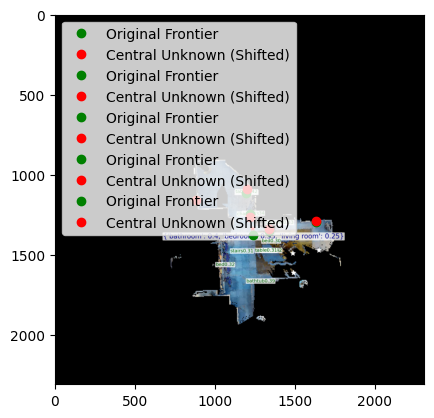

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.cluster import DBSCAN

# Load image
image_path = "/root/Projects/yhu/SG-VLN/dump/llm_regrouped_obs_prediction_top3/bev_gpt/mv2HUxq3B53_2/50_occ_map.png"
img = Image.open(image_path).convert("RGB")
img_np = np.array(img)

# Convert to grayscale
gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

# Threshold to binary to isolate frontier marker (white = 255) and unknown (black = 0)
_, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)  # White regions
unknown_mask = (gray < 10).astype(np.uint8)  # Very dark areas considered unknown

# Find coordinates of white frontier marker(s)
frontier_coords = np.argwhere(binary == 255)

# Find coordinates of unknown regions
unknown_coords = np.argwhere(unknown_mask == 1)

clustering = DBSCAN(eps=5, min_samples=10, metric='euclidean').fit(frontier_coords)
# Extract labels
labels = clustering.labels_

# Get unique labels (clusters), ignoring noise (-1)
unique_labels = set(labels)
unique_labels.discard(-1)  # remove noise label

# Compute the center of each cluster
cluster_centers = []
for label in unique_labels:
    points_in_cluster = frontier_coords[labels == label]
    center = points_in_cluster.mean(axis=0)
    cluster_centers.append(center)

# Convert to integer pixel coordinates if needed
cluster_centers = [center.astype(int) for center in cluster_centers]

# Output: list of (y, x) cluster centers
print("Cluster centers:", cluster_centers)

frontier_coords = np.array(cluster_centers)

def find_central_unknown(frontier_point, unknown_coords, radius=20):
    """
    Find a nearby unknown pixel within a radius that's closest to the frontier point.
    """
    y0, x0 = frontier_point
    candidates = [coord for coord in unknown_coords
                if np.linalg.norm(np.array(coord) - np.array([y0, x0])) <= radius]

    if not candidates:
        return None

    # Find the one closest to the center (frontier point)
    candidates = np.array(candidates)
    dists = np.linalg.norm(candidates - np.array([y0, x0]), axis=1)
    min_idx = np.argmin(dists)
    return tuple(candidates[min_idx])

# Plot result
fig, ax = plt.subplots()
ax.imshow(img_np)
for frontier_point in frontier_coords:
    # Apply the refined function
    central_unknown = find_central_unknown(frontier_point, unknown_coords, radius=40)
    ax.plot(frontier_point[1], frontier_point[0], 'go', label='Original Frontier')
    ax.plot(central_unknown[1], central_unknown[0], 'ro', label='Central Unknown (Shifted)')
    ax.legend()
plt.title("Frontier Shift to Nearby Central Unknown Region")
plt.axis("off")
plt.show()


In [ ]:




# Plot result
fig, ax = plt.subplots()
ax.imshow(img_np)
if central_unknown:
    ax.plot(frontier_point[1], frontier_point[0], 'go', label='Original Frontier')
    ax.plot(central_unknown[1], central_unknown[0], 'ro', label='Central Unknown (Shifted)')
    ax.legend()
plt.title("Frontier Shift to Nearby Central Unknown Region")
plt.axis("off")
plt.show()


ValueError: too many values to unpack (expected 2)

(10495, 2)